In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import kagglehub
import os
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter

In [14]:
path = kagglehub.dataset_download("jbalwaysus/simlex-999")

train_dataset_path = os.path.join(path, "SimLex-999.txt")

dataset_simlex = pd.read_csv(train_dataset_path, sep='\t')

print(dataset_simlex.shape)
print(dataset_simlex.head())

100%|██████████| 17.6k/17.6k [00:00<00:00, 26.5MB/s]

Extracting files...
(999, 10)
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


Main-dataset to train embedder:

In [2]:
path = kagglehub.dataset_download("thedevastator/tinystories-narrative-classification")
path = os.path.join(path, "train.csv")
dataset_stories = pd.read_csv(path)
print(dataset_stories.shape)
dataset_stories.head()

100%|██████████| 576M/576M [00:08<00:00, 75.1MB/s]

Extracting files...


(2119719, 1)


,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."


note: each of these story will be considered as a documentd for embedding creations and similarity stuff

Side-dataset to train embedder:

In [3]:
if False:
	dataset_wikitext = load_dataset("wikitext", "wikitext-2-raw-v1", split="train").to_pandas()

	# Access the raw text list
	text_data = dataset_wikitext["text"]
	print(text_data[3])

In [26]:
def evaluate_embedding(embedder):
	results = []
	# look at dataset_simlex
	for index, row in tqdm(dataset_simlex.iterrows(), total=dataset_simlex.shape[0]):
		word1 = row['word1']
		word2 = row['word2']
		simlex_score = row['SimLex999']

		emb1 = embedder.get_embedding(word1)
		emb2 = embedder.get_embedding(word2)

		if emb1 is not None and emb2 is not None:
			cosine_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
			# Store or print the cosine similarity and compare with simlex_score
			results.append((word1, word2, simlex_score, cosine_sim))
	results_df = pd.DataFrame(results, columns=['word1', 'word2', 'simlex_score', 'cosine_sim'])
	results_df["sim_to_cosine"] = (results_df["simlex_score"] / 5) - 1

	corr, _ = spearmanr(results_df['cosine_sim'], results_df['simlex_score'])
	print(f"\nSpearman Correlation: {corr}")

	return results_df

### Dataset Analysis (emb_pure_counts)

In [5]:
N_DOCS = 20000

In [6]:
tqdm.pandas()

docs_words = dataset_stories["text"].head(N_DOCS).reset_index(drop=True).progress_apply(
	lambda t: re.findall(r'\w+', t)
)
word_doc = docs_words.explode()

emb_pure_counts = pd.crosstab(word_doc, word_doc.index)
print(emb_pure_counts.shape)
emb_pure_counts.head(20)

100%|██████████| 20000/20000 [00:01<00:00, 17107.77it/s]


(13059, 20000)


col_0,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
text,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10th,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Compute document frequency (number of documents each term appears in)
df_word_doc = word_doc.reset_index()
df_word_doc.columns = ["doc", "word"]

# Count unique documents per word (document frequency)
doc_freq_per_term = df_word_doc.groupby("word")["doc"].nunique().sort_values(ascending=False)
print(doc_freq_per_term.shape)
doc_freq_per_term.head(20)

(13059,)


,doc
word,
and,19969
a,19910
to,19857
the,19683
was,18709
day,16124
it,15840
One,14486
there,14402


word
and      19969
a        19910
to       19857
the      19683
was      18709
day      16124
it       15840
One      14486
there    14402
in       14313
Name: doc, dtype: int64
word
day      16124
it       15840
One      14486
there    14402
in       14313
         ...  
7            1
6            1
œoh          1
œnow         1
œjust        1
Name: doc, Length: 13054, dtype: int64


[]

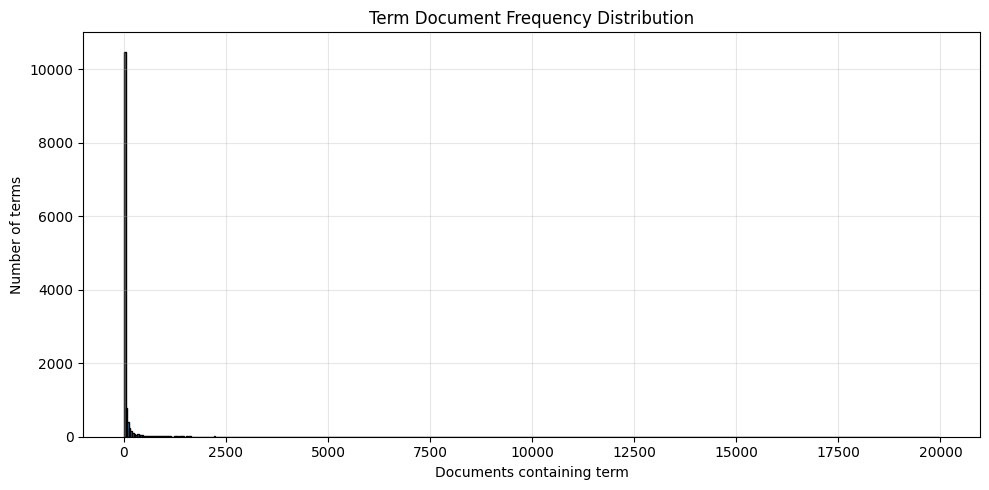

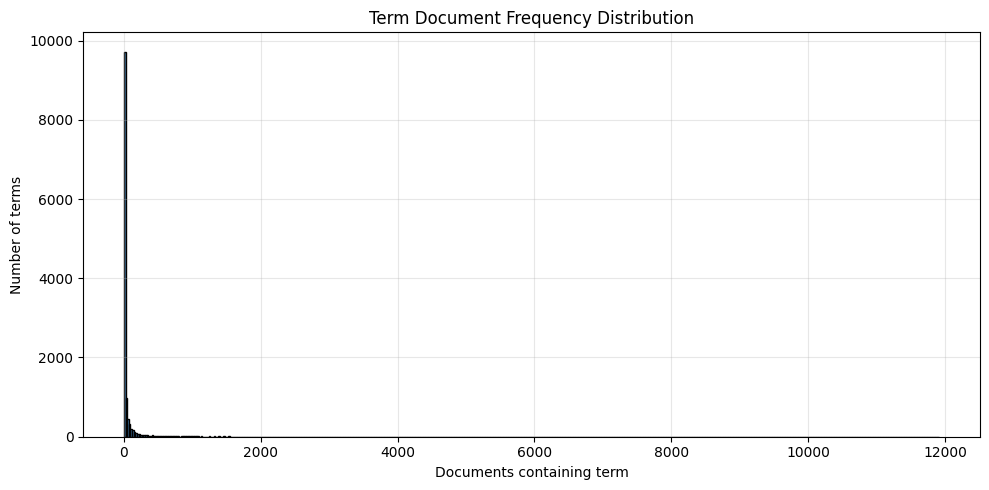

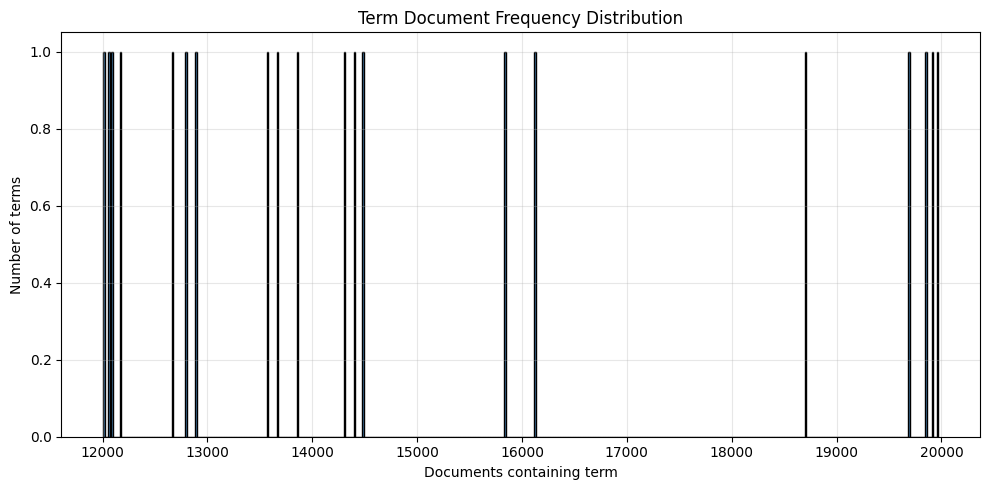

In [8]:
print(doc_freq_per_term[:10])
print(doc_freq_per_term[5:])


plt.figure(figsize=(10, 5))
plt.hist(doc_freq_per_term, bins=500, color="steelblue", edgecolor="black")
plt.xlabel("Documents containing term")
plt.ylabel("Number of terms")
plt.title("Term Document Frequency Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.plot()

plt.figure(figsize=(10, 5))
plt.hist(doc_freq_per_term[20:], bins=500, color="steelblue", edgecolor="black")
plt.xlabel("Documents containing term")
plt.ylabel("Number of terms")
plt.title("Term Document Frequency Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.plot()

plt.figure(figsize=(10, 5))
plt.hist(doc_freq_per_term[:20], bins=500, color="steelblue", edgecolor="black")
plt.xlabel("Documents containing term")
plt.ylabel("Number of terms")
plt.title("Term Document Frequency Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.plot()

## Sparse-Embeddings

Baseline embedder

### Random Embeddings

In [28]:
class RandomEmbedder:
	def __init__(self, dim=100):
		self.dim = dim

	def get_embedding(self, word):
		np.random.seed(hash(word) % (2**32))
		return np.random.randn(self.dim)

In [34]:
embRandom = RandomEmbedder(dim=100)
df_results_random = evaluate_embedding(embRandom)
print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_counting['cosine_sim'] - df_results_counting["sim_to_cosine"])}")

100%|██████████| 999/999 [00:00<00:00, 5211.86it/s]


Spearman Correlation: 0.020193646382305613
Average cosine similarity vs SimLex-999 score correlation: 0.18033735285271713


### Raw-Counting Embeddings

Each row is the embedding of each word, over the training vocabularies

In [30]:
class RawCounting:
	def __init__(self, emb_matrix):
		self.emb_matrix = emb_matrix

	def get_embedding(self, word):
		if word in self.emb_matrix.index:
			return self.emb_matrix.loc[word].values
		else:
			return None

In [31]:
embRawCounting = RawCounting(emb_pure_counts)

df_results_counting = evaluate_embedding(embRawCounting)

print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_counting['cosine_sim'] - df_results_counting["sim_to_cosine"])}")

100%|██████████| 999/999 [00:02<00:00, 454.93it/s]


Spearman Correlation: -0.0409346173757729
Average cosine similarity vs SimLex-999 score correlation: 0.18033735285271713


### Raw-Counting + PCA Embeddings

In [32]:
class RawCountingPCA:
	def __init__(self, emb_matrix):
		self.pca = PCA(n_components=100)
		self.emb_matrix = pd.DataFrame(self.pca.fit_transform(emb_matrix), index=emb_matrix.index)

	def get_embedding(self, word):
		if word in self.emb_matrix.index:
			return self.emb_matrix.loc[word].values
		else:
			return None

In [35]:
if False: # Care, the PCA takes a lot
	embRawCountingPCA = RawCountingPCA(emb_pure_counts)

	df_results_counting_pca = evaluate_embedding(embRawCountingPCA)

	print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_counting_pca['cosine_sim'] - df_results_counting_pca["sim_to_cosine"])}")

100%|██████████| 999/999 [00:00<00:00, 7508.40it/s]


Spearman Correlation: 0.11811802294410252
Average cosine similarity vs SimLex-999 score correlation: 0.34552476722900294


### TF-IDF Embeddings

In [36]:
class TfIdf:
    def __init__(self, emb_matrix):
        self.emb_matrix = pd.DataFrame(emb_matrix, index=emb_matrix.index)

        # TF
        tf = self.emb_matrix.copy().astype(float)
        mask = tf > 0
        tf[mask] = 1 + np.log10(tf[mask])

        # IDF
        N = self.emb_matrix.shape[1]
        df = (self.emb_matrix > 0).sum(axis=1)
        idf = np.log10(N / df)

        # TF-IDF
        self.emb_matrix = tf.multiply(idf, axis=0)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
if False:
    embRawCounting = TfIdf(emb_pure_counts)

    df_results_tfidf = evaluate_embedding(embRawCounting)

    print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_tfidf['cosine_sim'] - df_results_tfidf["sim_to_cosine"])}")

### PMI Embedding

In [ ]:
class PMI:
    def __init__(self, co_occurrence_matrix):
        matrix = co_occurrence_matrix.values
        total_count = matrix.sum()

        # Joint Probability
        p_xy = matrix / total_count

        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])

        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
if False:
    cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)
    embPMI = PMI(cooc_matrix)

    df_results_pmi = evaluate_embedding(embPMI)
    print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_pmi['cosine_sim'] - df_results_pmi['sim_to_cosine'])}")

### PMI K-Smoothing Embedding

In [ ]:
class PPMIKSmooth:
    def __init__(self, co_occurrence_matrix, k=0):
        matrix = co_occurrence_matrix.values.astype(float)

        if k > 0:
            matrix += k

        total_count = matrix.sum()

        # Joint Probability
        p_xy = matrix / total_count

        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])

        # PPMI
        pmi[pmi < 0] = 0
        pmi[np.isnan(pmi)] = 0
        pmi[np.isinf(pmi)] = 0

        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
if False:
    cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)

    embPPMI = PPMIKSmooth(cooc_matrix, k=1.0)

    df_results_ppmi = evaluate_embedding(embPPMI)
    print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_ppmi['cosine_sim'] - df_results_ppmi['sim_to_cosine'])}")

### PPMI Embedding

In [ ]:
class PPMI:
    def __init__(self, co_occurrence_matrix):
        matrix = co_occurrence_matrix.values
        total_count = matrix.sum()

        # Joint Probability
        p_xy = matrix / total_count

        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])

        # PPMI
        pmi[pmi < 0] = 0
        pmi[np.isnan(pmi)] = 0
        pmi[np.isinf(pmi)] = 0

        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
if False:
    cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)
    embPPMI = PPMI(cooc_matrix)

    df_results_ppmi = evaluate_embedding(embPPMI)
    print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_ppmi['cosine_sim'] - df_results_ppmi['sim_to_cosine'])}")

### PPMI K-Smoothing Embedding

In [ ]:
class PPMIKSmooth:
    def __init__(self, co_occurrence_matrix, k=0):
        matrix = co_occurrence_matrix.values.astype(float)

        if k > 0:
            matrix += k

        total_count = matrix.sum()

        # Joint Probability
        p_xy = matrix / total_count

        # Marginal Probabilities
        p_x = p_xy.sum(axis=1)
        p_y = p_xy.sum(axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            pmi = np.log2(p_xy) - np.log2(p_x[:, None]) - np.log2(p_y[None, :])

        # PPMI
        pmi[pmi < 0] = 0
        pmi[np.isnan(pmi)] = 0
        pmi[np.isinf(pmi)] = 0

        self.emb_matrix = pd.DataFrame(pmi, index=co_occurrence_matrix.index)

    def get_embedding(self, word):
        if word in self.emb_matrix.index:
            return self.emb_matrix.loc[word].values
        else:
            return None

In [ ]:
if False:
    cooc_matrix = emb_pure_counts.dot(emb_pure_counts.T)

    embPPMI = PPMI(cooc_matrix, k=1.0)

    df_results_ppmi = evaluate_embedding(embPPMI)
    print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_ppmi['cosine_sim'] - df_results_ppmi['sim_to_cosine'])}")

## Dense Embeddings

### Neural Probabilistic Language Model

In [16]:
# Configuration
CONTEXT_SIZE = 3
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
VOCAB_SIZE = 5000
BATCH_SIZE = 512
EPOCHS = 30

# Tokenization & Vocab Building
print("Building Vocabulary...")
all_text = " ".join(dataset_stories["text"].head(N_DOCS).astype(str))
tokens = re.findall(r'\w+', all_text.lower())

# Create mappings limited to top VOCAB_SIZE
word_counts = Counter(tokens)
most_common = word_counts.most_common(VOCAB_SIZE - 1)
vocab = ["<UNK>"] + [word for word, count in most_common]
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

# 2. Create N-Grams (Sliding Window)
print("Generating N-Grams...")
ngrams = []
for i in tqdm(range(len(tokens) - CONTEXT_SIZE)):
    context = [tokens[j] for j in range(i, i + CONTEXT_SIZE)]
    target = tokens[i + CONTEXT_SIZE]

    # Convert context words to indices
    context_idxs = [word_to_idx.get(w, 0) for w in context]
    target_idx = word_to_idx.get(target, 0)

    ngrams.append((context_idxs, target_idx))

Building Vocabulary...
Generating N-Grams...


100%|██████████| 3549765/3549765 [00:11<00:00, 318881.64it/s]


In [17]:
# PyTorch Dataset
class NgramDataset(Dataset):
    def __init__(self, ngrams):
        self.ngrams = ngrams

    def __len__(self):
        return len(self.ngrams)

    def __getitem__(self, idx):
        context, target = self.ngrams[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

dataloader = DataLoader(NgramDataset(ngrams), batch_size=BATCH_SIZE, shuffle=True)

class BengioNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
        super(BengioNLM, self).__init__()
        # Embedding Matrix
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Hidden Layer
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.activation = nn.Tanh() # Bengio used Tanh

        # Output Layer
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs):
        # Look up embeddings (batch_size, context_size, embedding_dim)
        embeds = self.embeddings(inputs)

        # Concatenate context vectors (batch_size, context_size * embedding_dim)
        embeds = embeds.view((inputs.shape[0], -1))

        # Hidden Layer
        out = self.linear1(embeds)
        out = self.activation(out)

        # Output Probabilities
        out = self.linear2(out)
        return out

class NeuralEmbedderWrapper:
    def __init__(self, model, word_to_idx):
        self.model = model
        self.word_to_idx = word_to_idx
        self.model.eval() # Set to eval mode

        # Move embeddings to CPU numpy for easy access
        self.embedding_matrix = self.model.embeddings.weight.detach().cpu().numpy()

    def get_embedding(self, word):
        # Lowercase to match training
        word = word.lower()
        if word in self.word_to_idx:
            idx = self.word_to_idx[word]
            return self.embedding_matrix[idx]
        else:
            return None

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

model = BengioNLM(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, HIDDEN_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import torch.nn.functional as F

def generate_text(model, start_words, num_to_generate, word_to_idx, idx_to_word):
    model.eval() # Switch to evaluation mode

    # 1. Tokenize and Pad
    words = start_words.lower().split()
    # Pad with <UNK> if we don't have enough words for the context
    while len(words) < CONTEXT_SIZE:
        words.insert(0, "<UNK>")

    # We only need the last CONTEXT_SIZE words to start
    current_context_words = words[-CONTEXT_SIZE:]

    generated_sequence = list(words) # Copy to store full result

    with torch.no_grad():
        for _ in range(num_to_generate):
            # 2. Convert to Indices
            context_idxs = [word_to_idx.get(w, 0) for w in current_context_words]
            input_tensor = torch.tensor([context_idxs], dtype=torch.long).to(device)

            # 3. Predict
            logits = model(input_tensor)
            probs = F.softmax(logits, dim=1)

            # 4. Sample from the distribution (adds variety)
            # Alternatively use .argmax() for the single most likely word
            predicted_idx = torch.multinomial(probs, num_samples=1).item()
            predicted_word = idx_to_word[predicted_idx]

            # 5. Append and Update Context
            generated_sequence.append(predicted_word)
            current_context_words.pop(0) # Remove oldest
            current_context_words.append(predicted_word) # Add newest

    model.train() # Switch back to training mode
    return " ".join(generated_sequence)

# Training Loop
for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for context, target in progress_bar:
        context, target = context.to(device), target.to(device)

        # Zero gradients
        model.zero_grad()

        # Forward pass
        log_probs = model(context)

        # Loss calculation
        loss = loss_function(log_probs, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss/len(dataloader))

    # Evaluation n.1 through simple text generation
    print(f"\n--- Epoch {epoch+1} Generation ---")
    generated = generate_text(model, "And so", 10, word_to_idx, idx_to_word)
    print(f"Output: And so {generated}\n")

    # Evaluation n.2 through previous SimLex Dataset
    neural_embedder = NeuralEmbedderWrapper(model, word_to_idx)
    df_results_neural = evaluate_embedding(neural_embedder)

    print(f"Average cosine similarity vs SimLex-999 score correlation: {np.mean(df_results_neural['cosine_sim'] - df_results_neural['sim_to_cosine'])}")

print("Training Complete.")

Training on cuda


Epoch 1/30: 100%|██████████| 6934/6934 [01:17<00:00, 89.47it/s, loss=4.24]



--- Epoch 1 Generation ---
Output: And so <UNK> and so drinking it was very rich the man said it was



100%|██████████| 999/999 [00:00<00:00, 19620.66it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.23675760549766886


Epoch 2/30: 100%|██████████| 6934/6934 [01:16<00:00, 91.15it/s, loss=3.8]



--- Epoch 2 Generation ---
Output: And so <UNK> and so let go of back her new friend timmy s mom



100%|██████████| 999/999 [00:00<00:00, 17412.07it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.2579402920120515


Epoch 3/30: 100%|██████████| 6934/6934 [01:17<00:00, 88.96it/s, loss=3.69]



--- Epoch 3 Generation ---
Output: And so <UNK> and so jenny shouted pointing to a bigger sound to the snowman



100%|██████████| 999/999 [00:00<00:00, 15197.53it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.2739430594689722


Epoch 4/30: 100%|██████████| 6934/6934 [01:17<00:00, 89.76it/s, loss=3.63]



--- Epoch 4 Generation ---
Output: And so <UNK> and so molly was something so out she put it on it



100%|██████████| 999/999 [00:00<00:00, 17060.78it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.28717114678549777


Epoch 5/30: 100%|██████████| 6934/6934 [01:19<00:00, 87.54it/s, loss=3.59]



--- Epoch 5 Generation ---
Output: And so <UNK> and so their mommy said yes you can you play and be



100%|██████████| 999/999 [00:00<00:00, 19348.58it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.2983180052736032


Epoch 6/30: 100%|██████████| 6934/6934 [01:17<00:00, 89.16it/s, loss=3.56]



--- Epoch 6 Generation ---
Output: And so <UNK> and so fast lily had won the race and had fun outside



100%|██████████| 999/999 [00:00<00:00, 19886.24it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.30802038697400735


Epoch 7/30: 100%|██████████| 6934/6934 [01:18<00:00, 88.27it/s, loss=3.53]



--- Epoch 7 Generation ---
Output: And so <UNK> and so he brought a delicious cookie wished she went outside and



100%|██████████| 999/999 [00:00<00:00, 20670.97it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3164090875109293


Epoch 8/30: 100%|██████████| 6934/6934 [01:16<00:00, 90.42it/s, loss=3.52]



--- Epoch 8 Generation ---
Output: And so <UNK> and so much that she liked she looked and made a new



100%|██████████| 999/999 [00:00<00:00, 20602.27it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3243848441435574


Epoch 9/30: 100%|██████████| 6934/6934 [01:15<00:00, 91.53it/s, loss=3.5]



--- Epoch 9 Generation ---
Output: And so <UNK> and so many fish and trucks she thinks everything is making a



100%|██████████| 999/999 [00:00<00:00, 20465.92it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3308465634128396


Epoch 10/30: 100%|██████████| 6934/6934 [01:22<00:00, 84.00it/s, loss=3.48]



--- Epoch 10 Generation ---
Output: And so <UNK> and so he picked up the windows but then she remembered what



100%|██████████| 999/999 [00:00<00:00, 20581.12it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3369461329096277


Epoch 11/30: 100%|██████████| 6934/6934 [01:15<00:00, 91.48it/s, loss=3.47]



--- Epoch 11 Generation ---
Output: And so <UNK> and so he said and his wonderful view he was so proud



100%|██████████| 999/999 [00:00<00:00, 20514.71it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3420989907616295


Epoch 12/30: 100%|██████████| 6934/6934 [01:18<00:00, 88.46it/s, loss=3.46]



--- Epoch 12 Generation ---
Output: And so <UNK> and so she tried to put him the pirate wandered and grabbed



100%|██████████| 999/999 [00:00<00:00, 20672.10it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3465736884311082


Epoch 13/30: 100%|██████████| 6934/6934 [01:17<00:00, 89.51it/s, loss=3.45]



--- Epoch 13 Generation ---
Output: And so <UNK> and so a little bit of shrimp but her dad told her



100%|██████████| 999/999 [00:00<00:00, 10217.06it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.35087186787404095


Epoch 14/30: 100%|██████████| 6934/6934 [01:17<00:00, 89.00it/s, loss=3.44]



--- Epoch 14 Generation ---
Output: And so <UNK> and so he decided to rule and tell a joke to ask



100%|██████████| 999/999 [00:00<00:00, 19028.05it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3544574907510115


Epoch 15/30: 100%|██████████| 6934/6934 [01:17<00:00, 89.85it/s, loss=3.44]



--- Epoch 15 Generation ---
Output: And so <UNK> and so he got an cut on the track benny saw the



100%|██████████| 999/999 [00:00<00:00, 20456.82it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.35816738310425367


Epoch 16/30: 100%|██████████| 6934/6934 [01:18<00:00, 88.81it/s, loss=3.43]



--- Epoch 16 Generation ---
Output: And so <UNK> and so he could fix his house his teacher found the key



100%|██████████| 999/999 [00:00<00:00, 19149.18it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.36113379814983176


Epoch 17/30: 100%|██████████| 6934/6934 [01:18<00:00, 88.79it/s, loss=3.42]



--- Epoch 17 Generation ---
Output: And so <UNK> and so they decided to go on adventures one day she tried



100%|██████████| 999/999 [00:00<00:00, 21251.36it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.36323899173251906


Epoch 18/30: 100%|██████████| 6934/6934 [01:18<00:00, 88.82it/s, loss=3.42]



--- Epoch 18 Generation ---
Output: And so <UNK> and so he kept watching in her backyard one day she saw



100%|██████████| 999/999 [00:00<00:00, 20095.97it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.36593672407498135


Epoch 19/30: 100%|██████████| 6934/6934 [01:19<00:00, 87.35it/s, loss=3.41]



--- Epoch 19 Generation ---
Output: And so <UNK> and so he wouldn t bottle because it didn t you like



100%|██████████| 999/999 [00:00<00:00, 9100.64it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3685192891133765


Epoch 20/30: 100%|██████████| 6934/6934 [01:19<00:00, 87.38it/s, loss=3.41]



--- Epoch 20 Generation ---
Output: And so <UNK> and so it quacked loudly really hard and the lights stopped and



100%|██████████| 999/999 [00:00<00:00, 16890.77it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.37055676017585776


Epoch 21/30: 100%|██████████| 6934/6934 [01:20<00:00, 86.62it/s, loss=3.4]



--- Epoch 21 Generation ---
Output: And so <UNK> and so it made the knife some crackers on her head suddenly



100%|██████████| 999/999 [00:00<00:00, 19546.25it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3720337565960741


Epoch 22/30: 100%|██████████| 6934/6934 [01:22<00:00, 84.45it/s, loss=3.4]



--- Epoch 22 Generation ---
Output: And so <UNK> and so he set off the knot they nodded and hugged the



100%|██████████| 999/999 [00:00<00:00, 20053.36it/s]


Average cosine similarity vs SimLex-999 score correlation: 0.3742446437331013


Epoch 23/30:   2%|▏         | 115/6934 [00:01<01:31, 74.16it/s, loss=0.0557]


KeyboardInterrupt: 

### Word2Vec